In [1]:
#тут все библеотеки и нужные для подгрзки вещи 

#Полезные вещи 
import pandas as pd
import matplotlib.pyplot as plt
#Прогресс-бар
from tqdm.auto import tqdm
tqdm.pandas()

#Все для подготовки
from Stemmer import Stemmer
from pymorphy2 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
nltk.download('stopwords') 
nltk.download('punkt')

#Все для обучения
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, roc_auc_score,
    classification_report, make_scorer
)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss 
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yngbb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yngbb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
raw_data = pd.read_excel("М.Тех_ТЗ_Датасет_DS_NLP.xlsx", index_col=0) #подгружаем данные 
#Приписываем лейблы к классам
labels = dict(enumerate(map(str, raw_data['class'].unique()))) 
labels_inv = {value: key for key, value in labels.items()}
raw_data['labels'] = raw_data['class'].map(labels_inv)

In [3]:
labels

{0: 'Консультация КЦ',
 1: 'Компетентность продавцов/ консультантов',
 2: 'Электронная очередь',
 3: 'Доступность персонала в магазине',
 4: 'Вежливость сотрудников магазина',
 5: 'Обслуживание на кассе',
 6: 'Обслуживание продавцами/ консультантами',
 7: 'Время ожидания у кассы'}

In [27]:
#Отчищаем текст и лемматизируем его для последующего обучения

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")  #Стоп-слвоа
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    
    return ' '.join(tokens)


In [28]:
raw_data['lemm'] = raw_data['text'].progress_apply(lemmatize)
raw_data.to_csv('prepared_data')

  0%|          | 0/2837 [00:00<?, ?it/s]

In [29]:
df = pd.read_csv('prepared_data', index_col = 0)
df

,id,text,class,labels,lemm
0,45,негатив к вам и горячей линии которые нафиг н...,Консультация КЦ,0,негатив горячий линия который нафиг нужный воо...
1,97,перестаньте впаривать клиентам дополнительные ...,Компетентность продавцов/ консультантов,1,перестать впаривать клиент дополнительный това...
2,105,продавец предложил наклеить защитную плёнку з...,Компетентность продавцов/ консультантов,1,продавец предложить наклеить защитный плёнка р...
3,127,продавец режил продать нам товар почему то по ...,Компетентность продавцов/ консультантов,1,продавец режить продать мы товар почему завыси...
4,130,навязанные услуги ( без моего согласия) на сум...,Компетентность продавцов/ консультантов,1,навязать услуга мой согласие сумма рубль
...,...,...,...,...,...
2832,17570,почему отключили электронную очередь через пол...,Электронная очередь,2,почему отключить электронный очередь получение...
2833,17579,очередь на кассе. продавцы не торопятся с зака...,Время ожидания у кассы,7,очередь касса продавец торопиться заказ разгов...
2834,17586,"профессионализма менеджеру бы, да и внимания к...",Обслуживание продавцами/ консультантами,6,профессионализм менеджер внимание клиент большой
2835,17591,сотрудник на выдаче заказа потребовал документ...,Электронная очередь,2,сотрудник выдача заказ потребовать документ уд...


In [7]:
#На этом обработка данных пока закончилась. С этого момента идет само обучение

In [8]:
#Функция для вывода матрицы ошибок. 
#На данной матрице легко определить количество правильно/неправильно спрогнозированных моделью значений.
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(16,10))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

In [9]:
#Делим выборку на тренировочную и тестовую.
x = df['lemm']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.25, stratify=y)

In [10]:
#Сравним несколько методов классификации
sgd_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])
knn_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn_clf', KNeighborsClassifier(n_neighbors=10))]) 
rnf_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rnf_clf', RandomForestClassifier())])


In [11]:
sgd_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
rnf_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rnf_clf', RandomForestClassifier())])

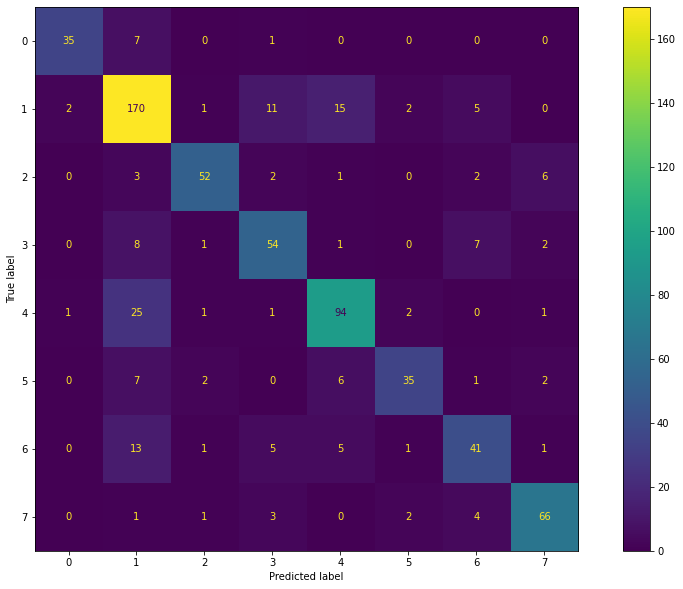

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        43
           1       0.73      0.83      0.77       206
           2       0.88      0.79      0.83        66
           3       0.70      0.74      0.72        73
           4       0.77      0.75      0.76       125
           5       0.83      0.66      0.74        53
           6       0.68      0.61      0.65        67
           7       0.85      0.86      0.85        77

    accuracy                           0.77       710
   macro avg       0.80      0.76      0.77       710
weighted avg       0.77      0.77      0.77       710



In [12]:
plot_confusion_matrix(y_test, sgd_clf.predict(X_test), sgd_clf)

print(classification_report(y_test, sgd_clf.predict(X_test))) 

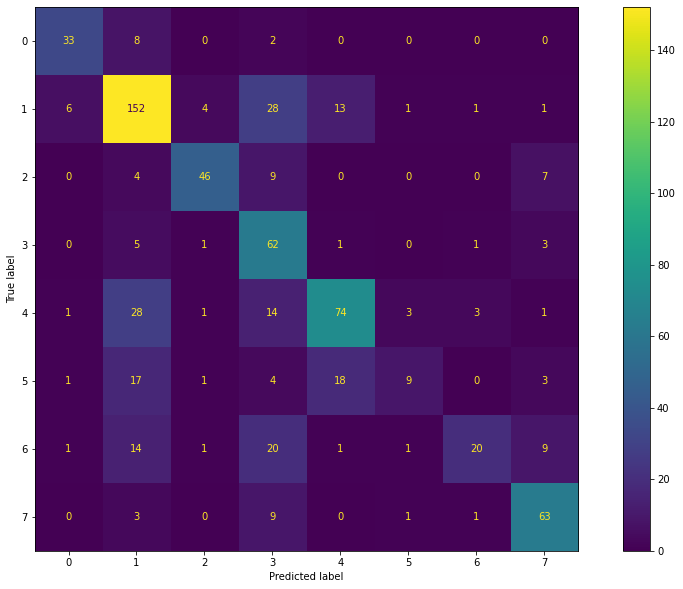

              precision    recall  f1-score   support

           0       0.79      0.77      0.78        43
           1       0.66      0.74      0.70       206
           2       0.85      0.70      0.77        66
           3       0.42      0.85      0.56        73
           4       0.69      0.59      0.64       125
           5       0.60      0.17      0.26        53
           6       0.77      0.30      0.43        67
           7       0.72      0.82      0.77        77

    accuracy                           0.65       710
   macro avg       0.69      0.62      0.61       710
weighted avg       0.68      0.65      0.63       710



In [13]:
plot_confusion_matrix(y_test, knn_clf.predict(X_test), sgd_clf)

print(classification_report(y_test, knn_clf.predict(X_test))) 

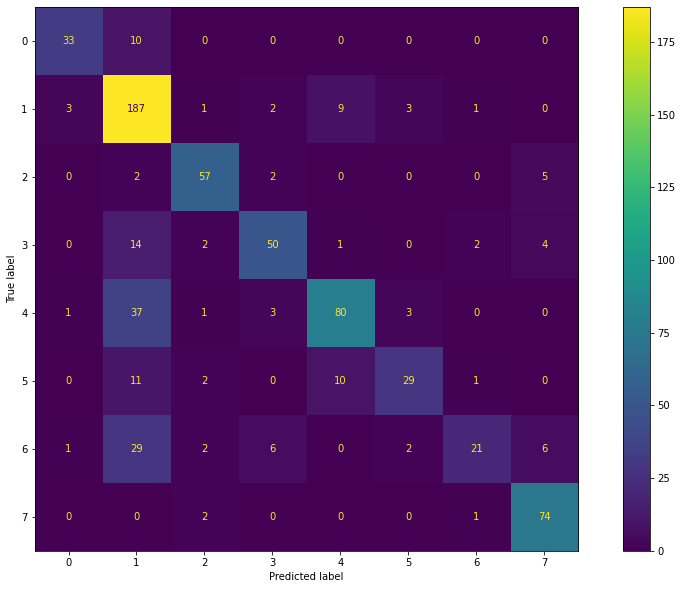

              precision    recall  f1-score   support

           0       0.87      0.77      0.81        43
           1       0.64      0.91      0.75       206
           2       0.85      0.86      0.86        66
           3       0.79      0.68      0.74        73
           4       0.80      0.64      0.71       125
           5       0.78      0.55      0.64        53
           6       0.81      0.31      0.45        67
           7       0.83      0.96      0.89        77

    accuracy                           0.75       710
   macro avg       0.80      0.71      0.73       710
weighted avg       0.77      0.75      0.74       710



In [14]:
plot_confusion_matrix(y_test, rnf_clf.predict(X_test), sgd_clf)

print(classification_report(y_test, rnf_clf.predict(X_test))) 

In [15]:
#SGD показал лучшие результаты, настроим для него гиперпараметры
param_grid = {
    'loss': ['log_loss', 'hinge'],
    'penalty': ['elasticnet', 'l1', None],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}
clf_grid = Pipeline([('tfidf', TfidfVectorizer()),
    ('gridsearch', GridSearchCV(SGDClassifier(random_state=42), param_grid, n_jobs=-1, scoring='f1_weighted'))])

clf_grid.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('gridsearch',
                 GridSearchCV(estimator=SGDClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001,
                                                    0.01, 0.1, 1],
                                          'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5,
                                                       0.8, 0.9, 0.95, 1],
                                          'loss': ['log_loss', 'hinge'],
                                          'penalty': ['elasticnet', 'l1',
                                                      None]},
                              scoring='f1_weighted'))])

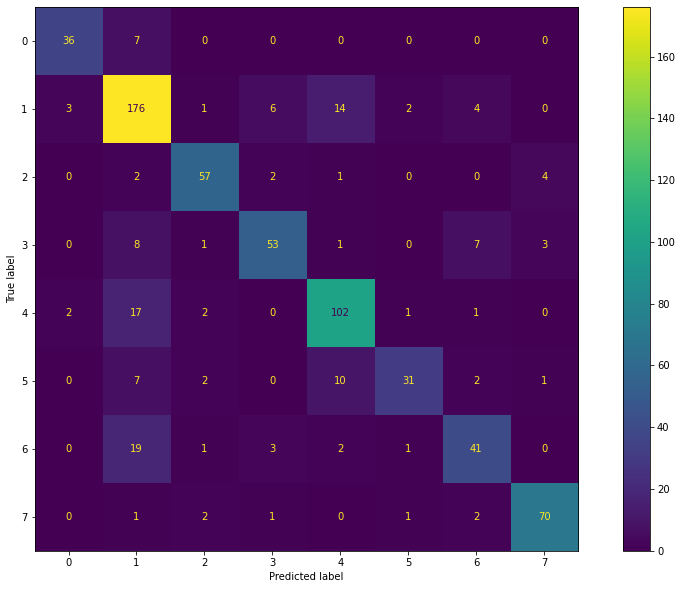

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        43
           1       0.74      0.85      0.79       206
           2       0.86      0.86      0.86        66
           3       0.82      0.73      0.77        73
           4       0.78      0.82      0.80       125
           5       0.86      0.58      0.70        53
           6       0.72      0.61      0.66        67
           7       0.90      0.91      0.90        77

    accuracy                           0.80       710
   macro avg       0.82      0.78      0.79       710
weighted avg       0.80      0.80      0.79       710



In [16]:
plot_confusion_matrix(y_test, clf_grid.predict(X_test), clf_grid)

print(classification_report(y_test, clf_grid.predict(X_test))) 

In [17]:
#По графикам видно, что на класс 1 (Компетентность продавцов/ консультантов) приходится больше всего ложных срабатываний.
df['class'].value_counts() #Класс 1 — мажоритарный и поэтому при обучении модели она наиболее сильно ориентируется на данные полученные из текстов данного класса.

class
Компетентность продавцов/ консультантов    825
Вежливость сотрудников магазина            500
Время ожидания у кассы                     306
Доступность персонала в магазине           293
Обслуживание продавцами/ консультантами    267
Электронная очередь                        264
Обслуживание на кассе                      212
Консультация КЦ                            170
Name: count, dtype: int64

In [18]:
#Воспользуемся undersampling методом NearMiss
nr = NearMiss()
vectorizer = TfidfVectorizer(min_df=30)
vect_x = vectorizer.fit_transform(x)

X_miss, y_miss = nr.fit_resample(vect_x, y) 

y_miss.value_counts()

labels
0    170
1    170
2    170
3    170
4    170
5    170
6    170
7    170
Name: count, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    vect_x, y, random_state=42, test_size=0.25,stratify=y
)

In [20]:
X_train.shape

(2127, 314)

In [21]:
miss_sgd_clf = Pipeline([
    ('gridsearch', GridSearchCV(SGDClassifier(random_state=42), param_grid, n_jobs=-1, scoring='f1_weighted'))])
miss_sgd_clf.fit(X_train, y_train)


Pipeline(steps=[('gridsearch',
                 GridSearchCV(estimator=SGDClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001,
                                                    0.01, 0.1, 1],
                                          'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5,
                                                       0.8, 0.9, 0.95, 1],
                                          'loss': ['log_loss', 'hinge'],
                                          'penalty': ['elasticnet', 'l1',
                                                      None]},
                              scoring='f1_weighted'))])

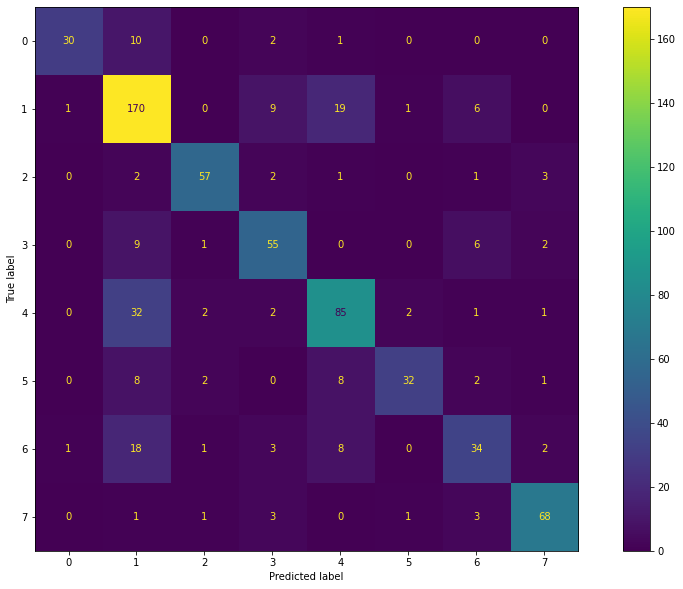

              precision    recall  f1-score   support

           0       0.94      0.70      0.80        43
           1       0.68      0.83      0.75       206
           2       0.89      0.86      0.88        66
           3       0.72      0.75      0.74        73
           4       0.70      0.68      0.69       125
           5       0.89      0.60      0.72        53
           6       0.64      0.51      0.57        67
           7       0.88      0.88      0.88        77

    accuracy                           0.75       710
   macro avg       0.79      0.73      0.75       710
weighted avg       0.76      0.75      0.75       710



In [22]:
plot_confusion_matrix(y_test, miss_sgd_clf.predict(X_test), miss_sgd_clf)
print(classification_report(y_test, miss_sgd_clf.predict(X_test))) 
#Особых резульатов не дало 

In [23]:
pickle.dump(clf_grid, open('Mtex_clf', "wb")) #сохраняем модель с лучшим f-1 

In [24]:
clf_grid.predict(df['lemm'].loc[0:10]) #микротестим на адекватность 

array([0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1], dtype=int64)

In [25]:
df['labels'].loc[0:10]

0     0
1     1
2     1
3     1
4     1
5     0
6     1
7     2
8     2
9     1
10    1
Name: labels, dtype: int64

In [ ]:
'''
Выводы: 
В целом результат удвалитворителен.
Из-за несбалансированной выборки точность снижена.
Решение:
Получить больше данных, и затем применить undersampling методы.
Использовать трансформеры для обучения
Разбить класс "Компетентность продавцов/ консультантов" на более узкие классы 
'''